## Notebook que faz a reconstrução dos tiles.


É aplicado o modelo nos patches de um tile, obtém-se a predição de classes dos patches, e monta o tile a partir dos patches. 

In [1]:
import torch

def print_gpu_memory(prefix=""):
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"{prefix} Memory Allocated: {allocated:.2f} MB")
        print(f"{prefix} Memory Reserved: {reserved:.2f} MB")
    else:
        print("CUDA is not available.")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache() 

print_gpu_memory()

 Memory Allocated: 0.00 MB
 Memory Reserved: 0.00 MB


In [2]:
# imports

import os
import sys
sys.path.append(os.path.abspath('..'))

import src.data.preprocess_data as data
import src.training.train_model as train
import src.data.view as view
import src.models.unets as unets
import src.models.hrnets as hrnets
import src.training.post_processing as post

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

/home/jonathan/UrbanizedAreasSegmentation/.venv/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
## definições

tile = '032027'
num_subtiles = 6
num_classes = 5
working_dir = os.path.abspath('..')
folder = os.path.join(working_dir,f"data/processed/S2-16D_V2_{tile}/{num_subtiles}x{num_subtiles}_subtiles")
files = os.listdir(folder)
files = [os.path.join(folder, f) for f in files if f.endswith('.tif')]

classes_mode = 'type'
if classes_mode == 'type':
    num_classes = 5
elif classes_mode == 'density':
    num_classes = 4
elif classes_mode == 'binary':
    num_classes = 2
elif classes_mode == 'all':
    num_classes = 9


Escolha do modelo

In [4]:
models = [#{'model_name': 'UNet-256-type-DS-CEW', 'patch_size':256, 'batch_size':16, 'note': 'best recall on class 1 on test set, choice on val set'},
          #{'model_name': 'UNet-256-type-DS-CE', 'patch_size':256, 'batch_size':16, 'note': 'best on weigted recall on test set, best on class 1 precision, choice on val set'},
          #{'model_name': 'HRNetW18-512-type-CEW', 'patch_size':512, 'batch_size':4, 'note': 'best recall on class 2 on test set'},
          #{'model_name': 'HRNetW32-512-type-CE', 'patch_size':512, 'batch_size':4, 'note': 'best recall on class 0 on test set'},

          {'model_name': 'UNet-64-type-DS-CEW', 'patch_size':64, 'batch_size':16, 'note': 'best recall on class 3 on test set, best on macro recall on test set'},
          #{'model_name': 'UNet-64-type-CEW', 'patch_size':64, 'batch_size':16, 'note': 'best recall on class 4 on test set'},
          #---
          #{'model_name': 'UNet-64-type-DS-CE', 'patch_size':64, 'batch_size':16, 'note': 'best f1 on class 0 on test set'},
          #{'model_name': 'UNetResNet34-224-type-DS-CE', 'patch_size':224, 'batch_size':16, 'note': 'best f1 on class 1 on test set, best macro precision, choice on val set, choice on val set'},
          #{'model_name': 'UNetSmall-64-type-CEW', 'patch_size':64, 'batch_size':16, 'note': 'best macro f1 on test set, best f1 on class 2 on test set'},
          #{'model_name': 'UNetEfficientNetB0-224-type-DS-CE', 'patch_size':224, 'batch_size':16, 'note': 'best f1 and precision on class 3 on test set'},
          #{'model_name': 'UNetSmall-64-type-DS-CE', 'patch_size':64, 'batch_size':16, 'note': 'best f1 on class 4 on test set'},
          #{'model_name': 'UNet-256-type-CEW', 'patch_size':256, 'batch_size':16, 'note': 'best global f1 on test set'},
          #----
          #{'model_name': 'UNetSmall-64-type-DS-CEW', 'patch_size':64, 'batch_size':16, 'note': 'best precision on class 0 on test set'},
          #{'model_name': 'HRNetW48-512-type-DS-CE', 'patch_size':512, 'batch_size':4, 'note': 'best precision on class 2 on test set'},
          #{'model_name': 'UNetConvNext-224-type-DS-CEW', 'patch_size':224, 'batch_size':16, 'note': 'best precision on class 4 on test set, choise on validation'},
          #{'model_name': 'UNetEfficientNetB0-224-type-DS-CEW', 'patch_size':224, 'batch_size':16, 'note': 'best global precision on test set'},
          
          # train and test:
          #{'model_name': 'UNetSmall-256-type-DS-CEW', 'patch_size':256, 'batch_size':16, 'note': 'selected from validation'},
          #{'model_name': 'UNetSmall-256-type-DS-CE', 'patch_size':256, 'batch_size':16, 'note': 'selected from validation'},
          #{'model_name': 'UNetResNet34-224-type-DS-CEW', 'patch_size':224, 'batch_size':16, 'note': 'selected from validation'},

          ]

models = [{'model_name': 'UNet-256-type-DS-CE', 'patch_size':256, 'batch_size':16, 'note': 'best acc, f1 macro, f1 micro on val set'},
          {'model_name': 'UNetSmall-64-type-DS-CE', 'patch_size':64, 'batch_size':16, 'note': '2nd best acc and , f1 micro on val set'},
          {'model_name': 'UNetSmall-64-type-CEW', 'patch_size':64, 'batch_size':16, 'note': '2ds best macro f1 on val set'},
          {'model_name': 'UNetResNet34-224-type-DS-CE', 'patch_size':224, 'batch_size':16, 'note': '3rd best acc, macro and micro f1 on val set'},
          ]


## Loop principal, que faz a inferência dos patches e monta o tile

Model name: UNet-256-type-DS-CE
Inferindo...
running...


100%|██████████| 144/144 [01:25<00:00,  1.68it/s]


Montando...
Salvando...
[0, 1760, 3520, 5280, 7040, 8800]
[0, 1760, 3520, 5280, 7040, 8800]
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNet-256-type-DS-CE/S2-16D_V2_032027_x=0_y=0.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNet-256-type-DS-CE/S2-16D_V2_032027_x=0_y=1760.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNet-256-type-DS-CE/S2-16D_V2_032027_x=0_y=3520.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNet-256-type-DS-CE/S2-16D_V2_032027_x=0_y=5280.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNet-256-type-DS-CE/S2-16D_V2_032027_x=0_y=7040.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNet-256-type-DS-CE/S2-16D_V2_032027_x=0_y=8800.tif
Saving as /home/jonathan/Urba

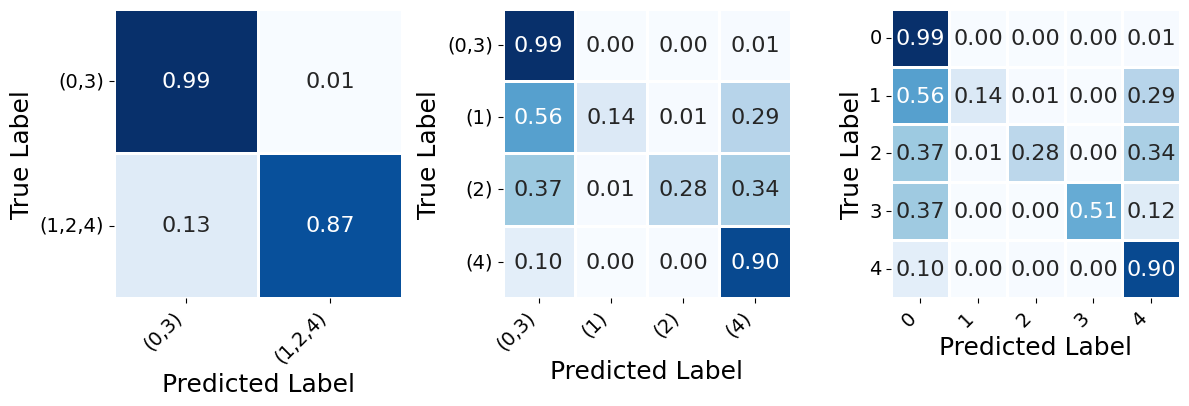

              precision    recall  f1-score    support           TP  \
Class 0        0.990183  0.992566  0.991373  140479904  139435472.0   
Class 1        0.526770  0.139659  0.220783     361689      50513.0   
Class 2        0.600999  0.280819  0.382782     550037     154461.0   
Class 3        0.957026  0.511199  0.666425     138361      70730.0   
Class 4        0.870210  0.896432  0.883127    9465038    8484765.0   
weighted avg   0.980105  0.981463  0.980227  150995040          0.0   
macro avg      0.789038  0.564135  0.628898  150995040          0.0   
micro avg      0.981463  0.981463  0.981463  150995040          0.0   

                     FP           TN         FN  
Class 0       1382391.0    9132734.0  1044318.0  
Class 1         45379.0  150587920.0   311176.0  
Class 2        102546.0  150342400.0   395576.0  
Class 3          3176.0  150853440.0    67631.0  
Class 4       1265482.0  140264480.0   980273.0  
weighted avg        0.0          0.0        0.0  
macro avg 

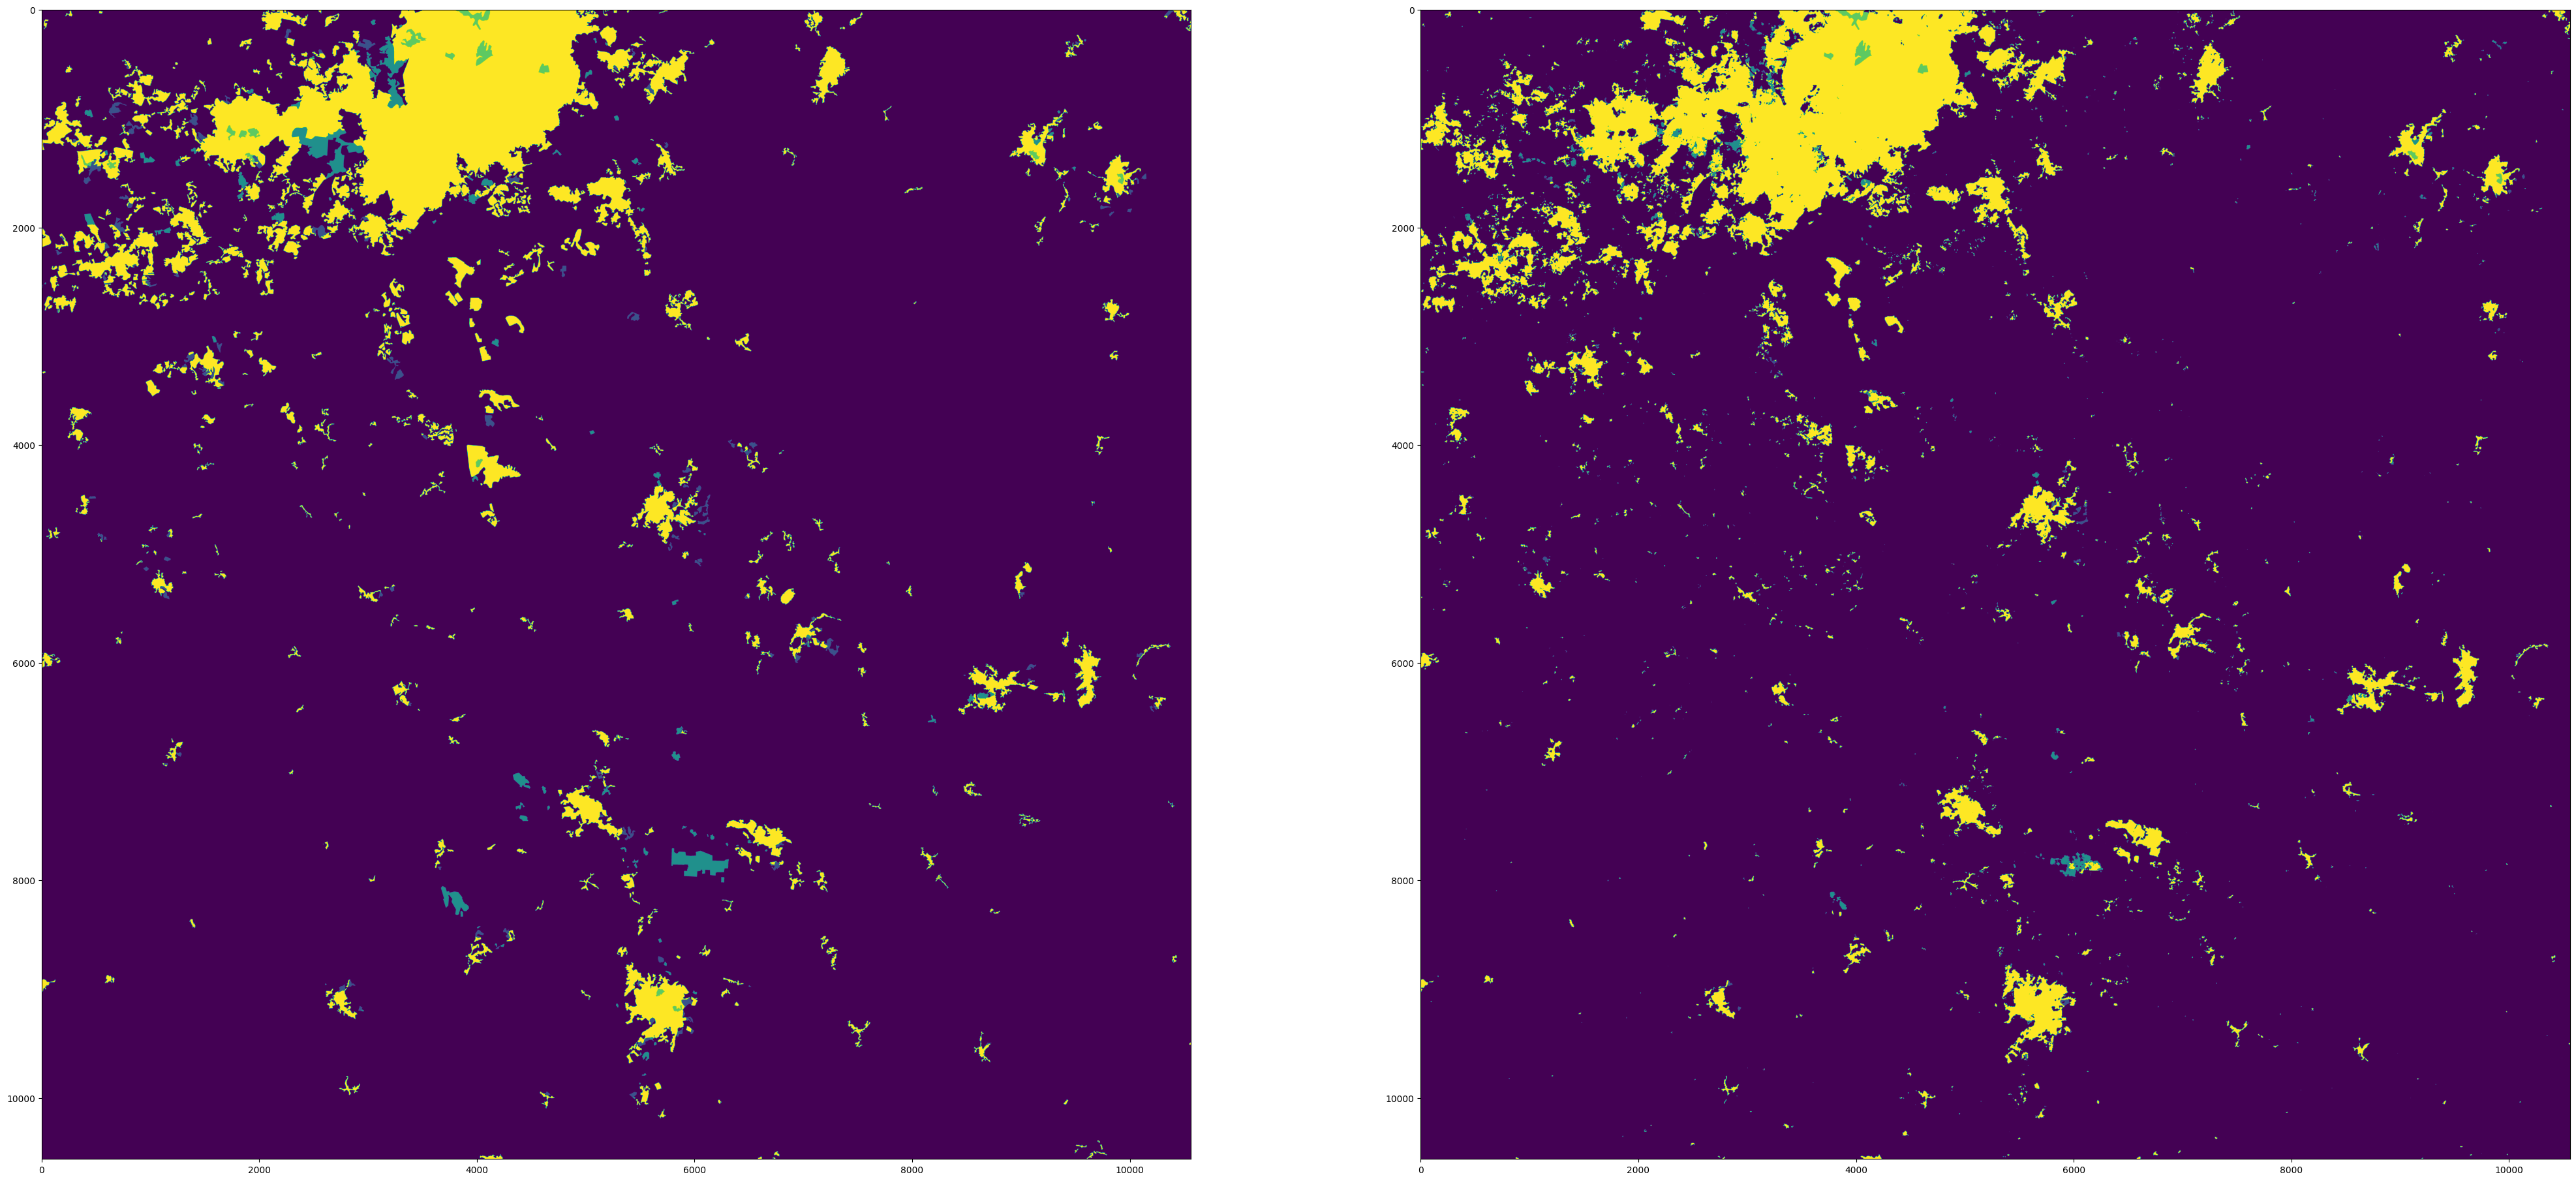

Model name: UNetSmall-64-type-DS-CE
Inferindo...
running...


100%|██████████| 3081/3081 [05:14<00:00,  9.79it/s]


Montando...
Salvando...
[0, 1760, 3520, 5280, 7040, 8800]
[0, 1760, 3520, 5280, 7040, 8800]
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-DS-CE/S2-16D_V2_032027_x=0_y=0.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-DS-CE/S2-16D_V2_032027_x=0_y=1760.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-DS-CE/S2-16D_V2_032027_x=0_y=3520.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-DS-CE/S2-16D_V2_032027_x=0_y=5280.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-DS-CE/S2-16D_V2_032027_x=0_y=7040.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-DS-CE/S2-16D_V2_032027_x=0_y=8800.tif
Savin

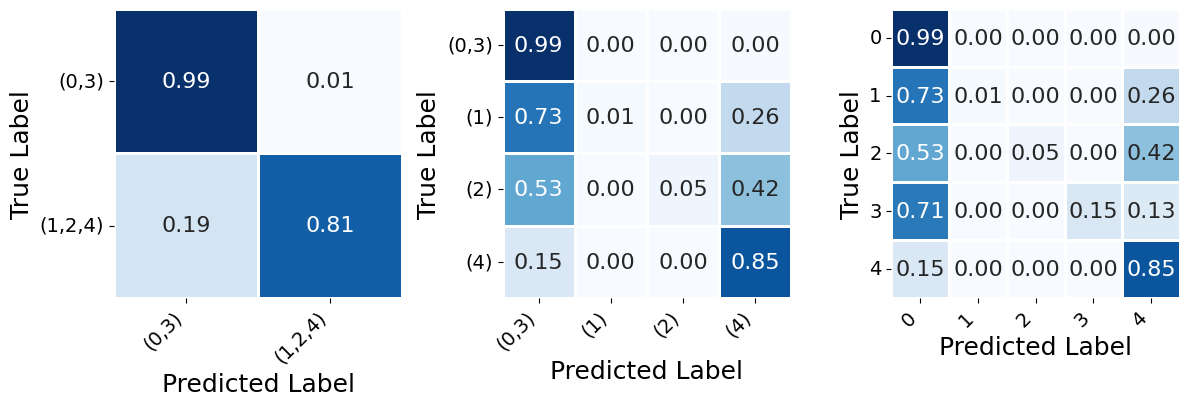

              precision    recall  f1-score    support           TP  \
Class 0        0.985576  0.994627  0.990081  187700976  186692624.0   
Class 1        0.270955  0.008979  0.017383     471964       4238.0   
Class 2        0.552116  0.048889  0.089825     751922      36761.0   
Class 3        0.245127  0.153973  0.189140     189468      29173.0   
Class 4        0.888276  0.852642  0.870094   12753165   10873884.0   
weighted avg   0.975449  0.979041  0.976121  201867504          0.0   
macro avg      0.588410  0.411822  0.431305  201867504          0.0   
micro avg      0.979041  0.979041  0.979041  201867504          0.0   

                     FP           TN         FN  
Class 0       2732231.0   11434288.0  1008503.0  
Class 1         11403.0  201384016.0   467726.0  
Class 2         29821.0  201085776.0   715161.0  
Class 3         89839.0  201588032.0   160295.0  
Class 4       1367672.0  187746768.0  1879281.0  
weighted avg        0.0          0.0        0.0  
macro avg 

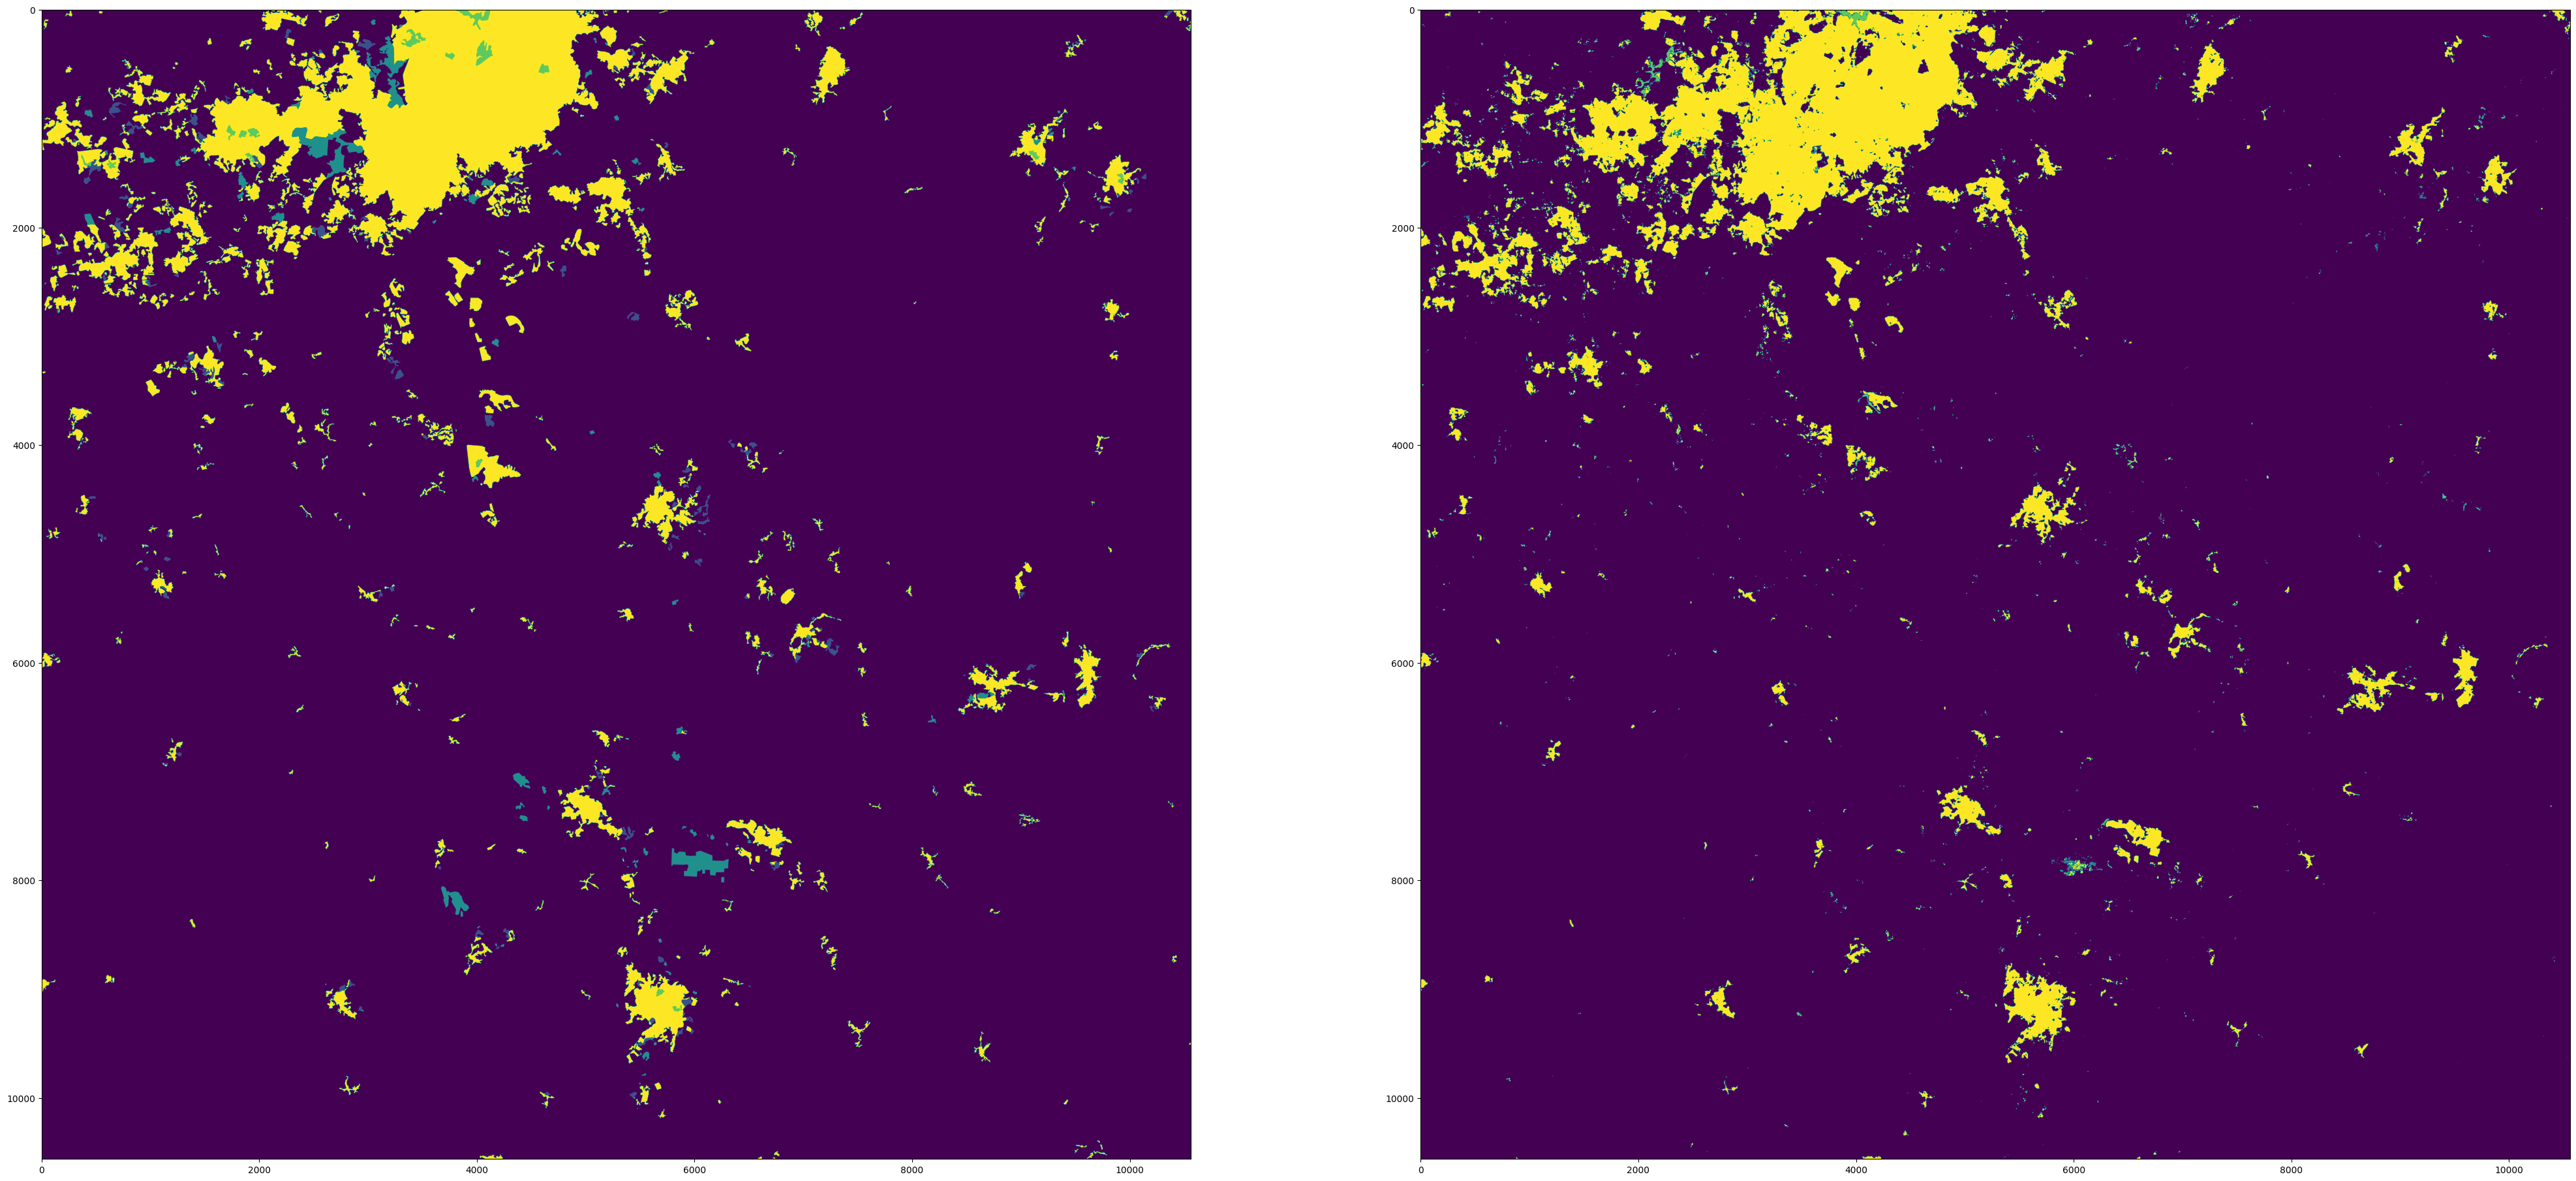

Model name: UNetSmall-64-type-CEW
Inferindo...
running...


100%|██████████| 3081/3081 [05:13<00:00,  9.84it/s]


Montando...
Salvando...
[0, 1760, 3520, 5280, 7040, 8800]
[0, 1760, 3520, 5280, 7040, 8800]
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-CEW/S2-16D_V2_032027_x=0_y=0.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-CEW/S2-16D_V2_032027_x=0_y=1760.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-CEW/S2-16D_V2_032027_x=0_y=3520.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-CEW/S2-16D_V2_032027_x=0_y=5280.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-CEW/S2-16D_V2_032027_x=0_y=7040.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetSmall-64-type-CEW/S2-16D_V2_032027_x=0_y=8800.tif
Saving as /home/j

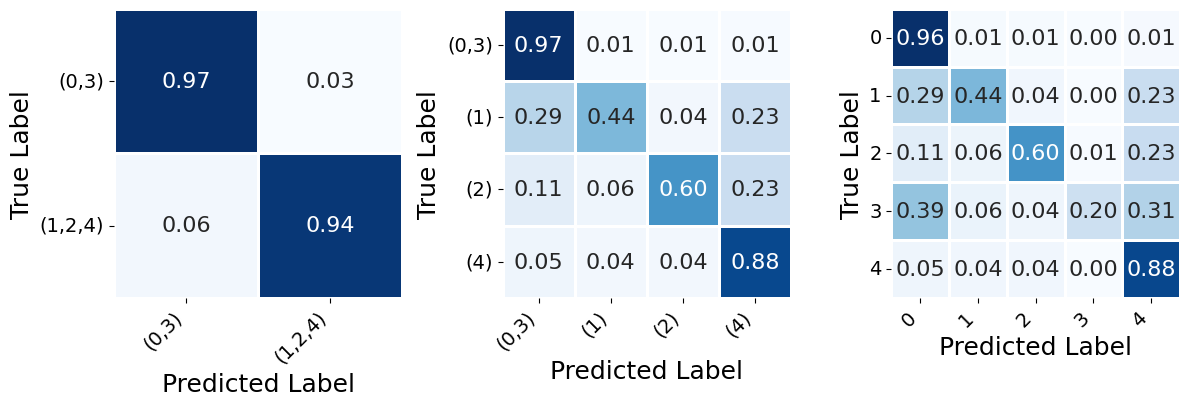

              precision    recall  f1-score    support           TP  \
Class 0        0.995075  0.962672  0.978606  187700976  180694976.0   
Class 1        0.087731  0.442203  0.146414     471964     208704.0   
Class 2        0.140788  0.597571  0.227886     751922     449327.0   
Class 3        0.064026  0.204319  0.097499     189468      38712.0   
Class 4        0.792655  0.876590  0.832512   12753165   11179300.0   
weighted avg   0.976110  0.953946  0.963807  201867504          0.0   
macro avg      0.416055  0.616671  0.456583  201867504          0.0   
micro avg      0.953946  0.953946  0.953946  201867504          0.0   

                     FP           TN         FN  
Class 0        894283.0   13272236.0  7006437.0  
Class 1       2170202.0  199226176.0   263260.0  
Class 2       2742195.0  198374080.0   302595.0  
Class 3        565917.0  201112256.0   150756.0  
Class 4       2924316.0  186190752.0  1573865.0  
weighted avg        0.0          0.0        0.0  
macro avg 

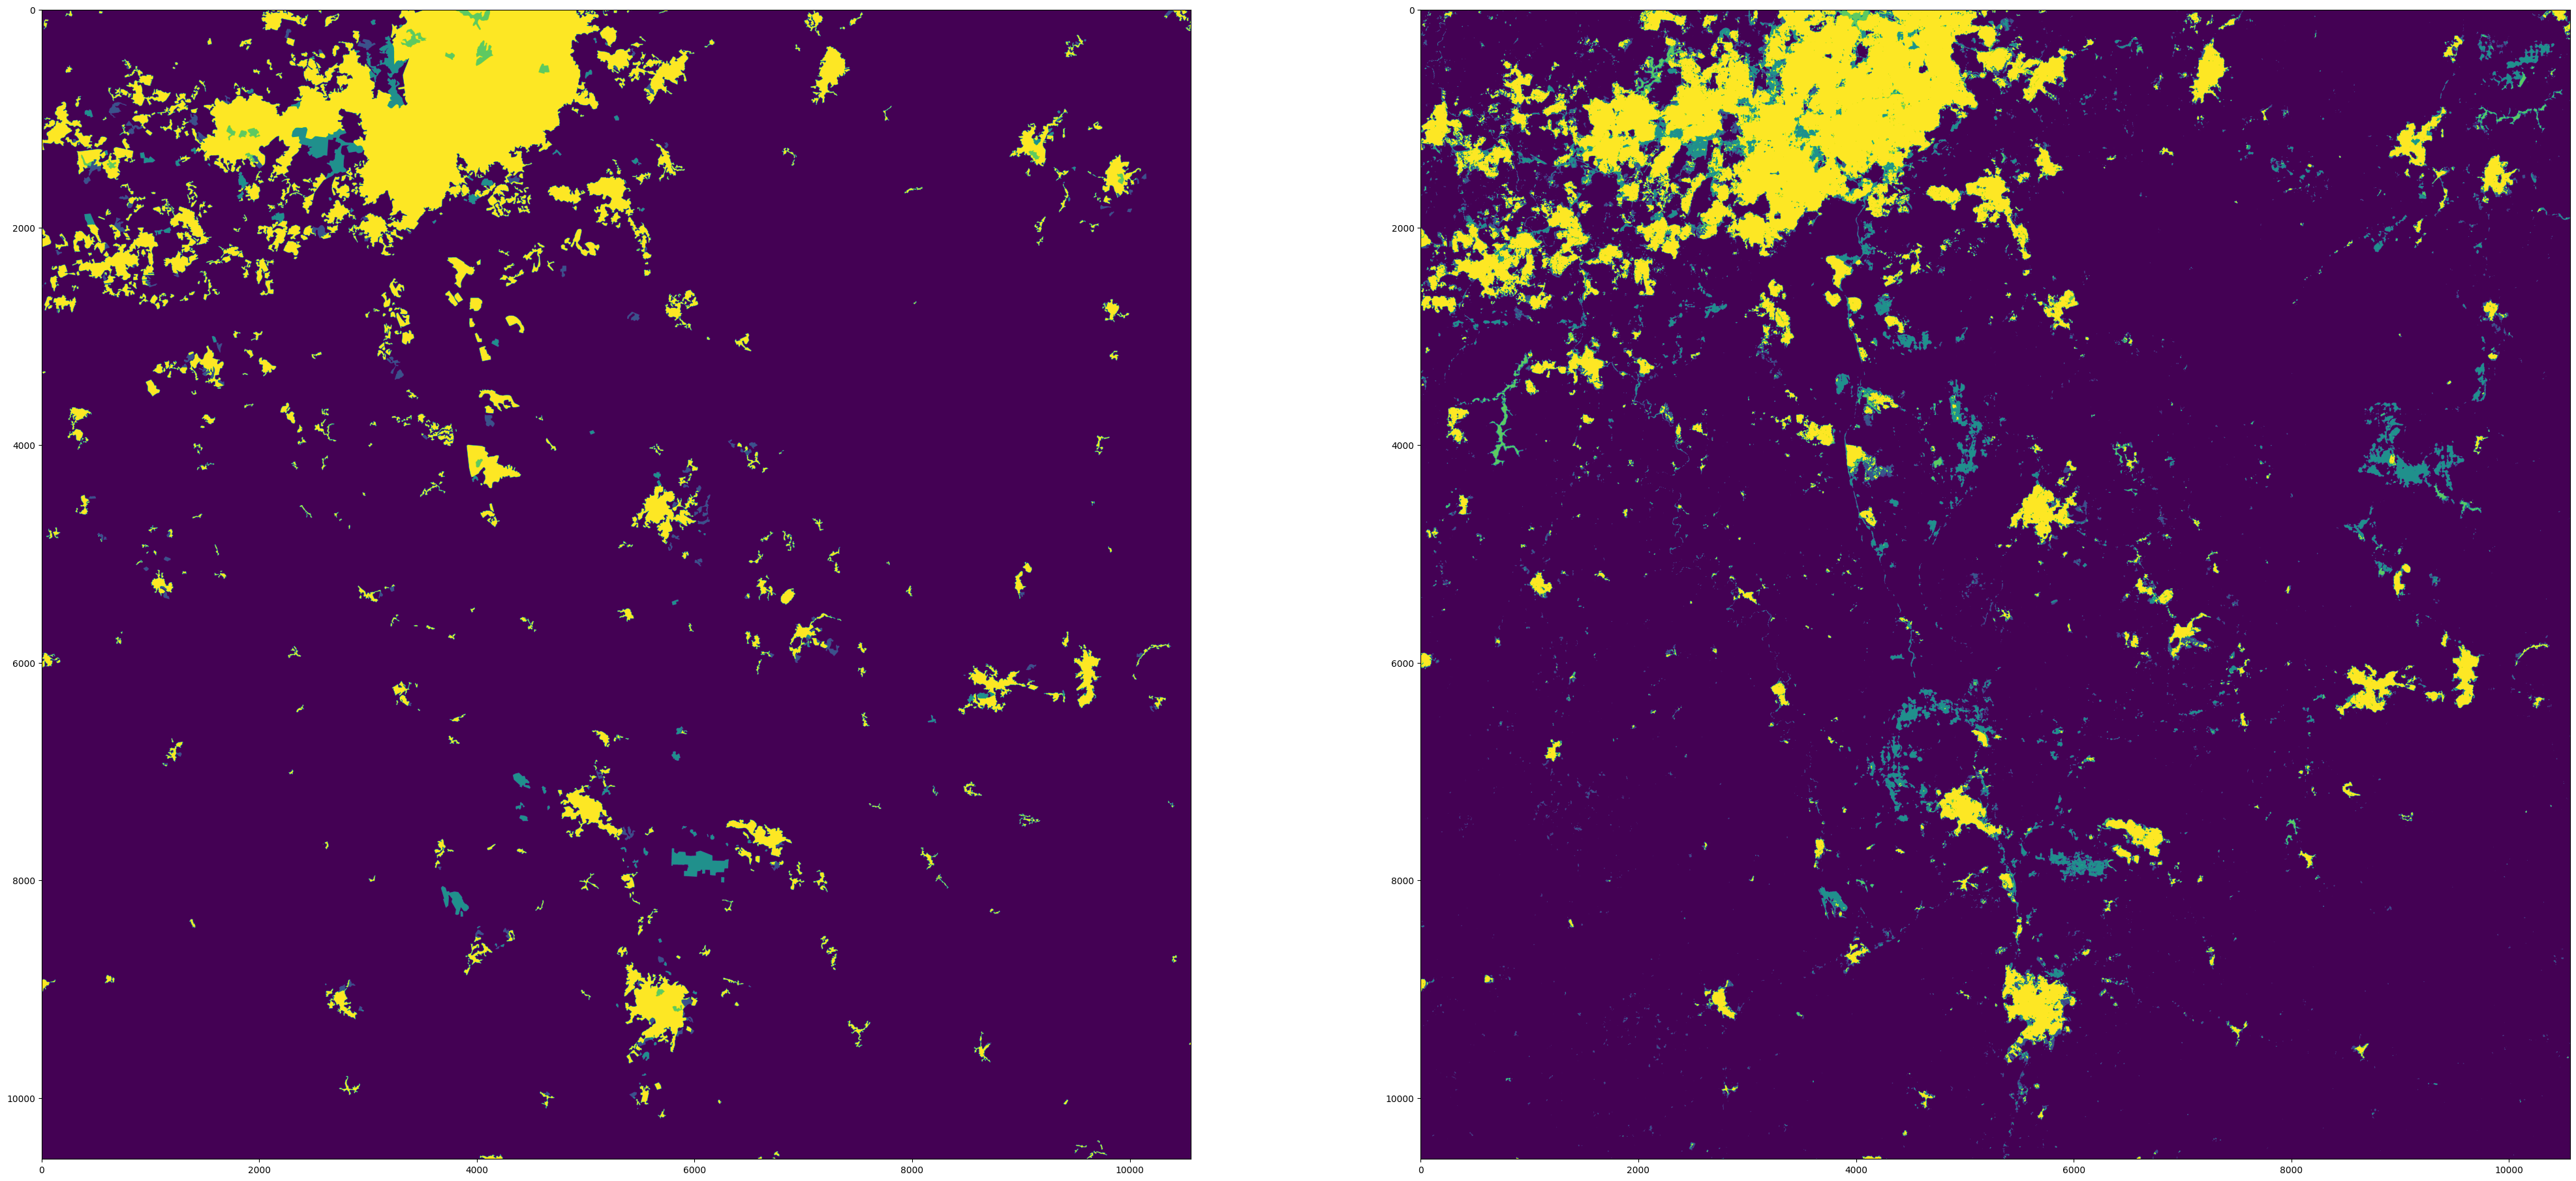

Model name: UNetResNet34-224-type-DS-CE
Inferindo...
running...


100%|██████████| 225/225 [01:22<00:00,  2.73it/s]


Montando...
Salvando...
[0, 1760, 3520, 5280, 7040, 8800]
[0, 1760, 3520, 5280, 7040, 8800]
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetResNet34-224-type-DS-CE/S2-16D_V2_032027_x=0_y=0.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetResNet34-224-type-DS-CE/S2-16D_V2_032027_x=0_y=1760.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetResNet34-224-type-DS-CE/S2-16D_V2_032027_x=0_y=3520.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetResNet34-224-type-DS-CE/S2-16D_V2_032027_x=0_y=5280.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetResNet34-224-type-DS-CE/S2-16D_V2_032027_x=0_y=7040.tif
Saving as /home/jonathan/UrbanizedAreasSegmentation/data/results/S2-16D_V2_032027/6x6_subtiles/UNetResNet34-224-type-DS-CE/S2-16D_V2_032

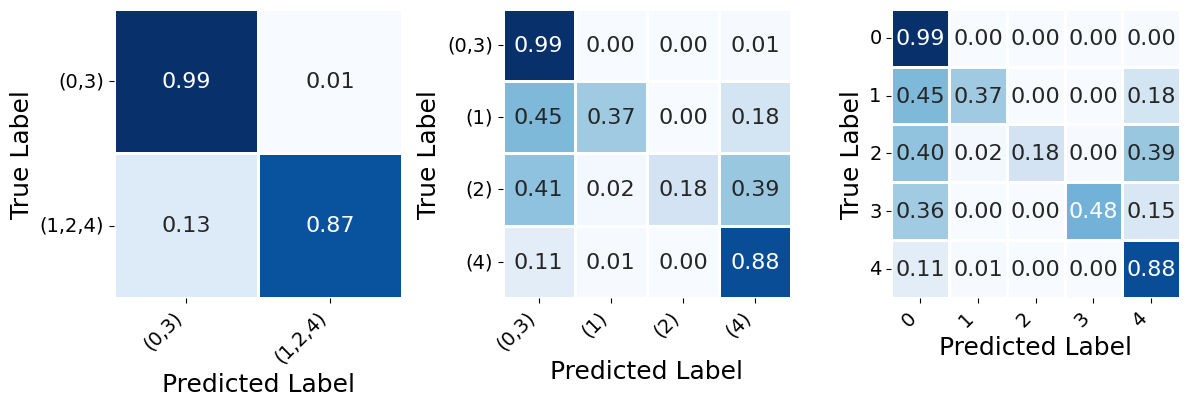

              precision    recall  f1-score    support           TP  \
Class 0        0.990058  0.994039  0.992045  168355424  167351648.0   
Class 1        0.422830  0.370064  0.394692     425699     157536.0   
Class 2        0.615205  0.183963  0.283232     615640     113255.0   
Class 3        0.859366  0.480101  0.616040     162751      78137.0   
Class 4        0.893730  0.884004  0.888840   11074104    9789554.0   
weighted avg   0.981420  0.982599  0.981555  180633632          0.0   
macro avg      0.756238  0.582435  0.634970  180633632          0.0   
micro avg      0.982599  0.982599  0.982599  180633632          0.0   

                     FP           TN         FN  
Class 0       1680520.0   10597674.0  1003509.0  
Class 1        215039.0  179992976.0   268163.0  
Class 2         70838.0  179947168.0   502385.0  
Class 3         12787.0  180458064.0    84614.0  
Class 4       1164037.0  168395360.0  1284550.0  
weighted avg        0.0          0.0        0.0  
macro avg 

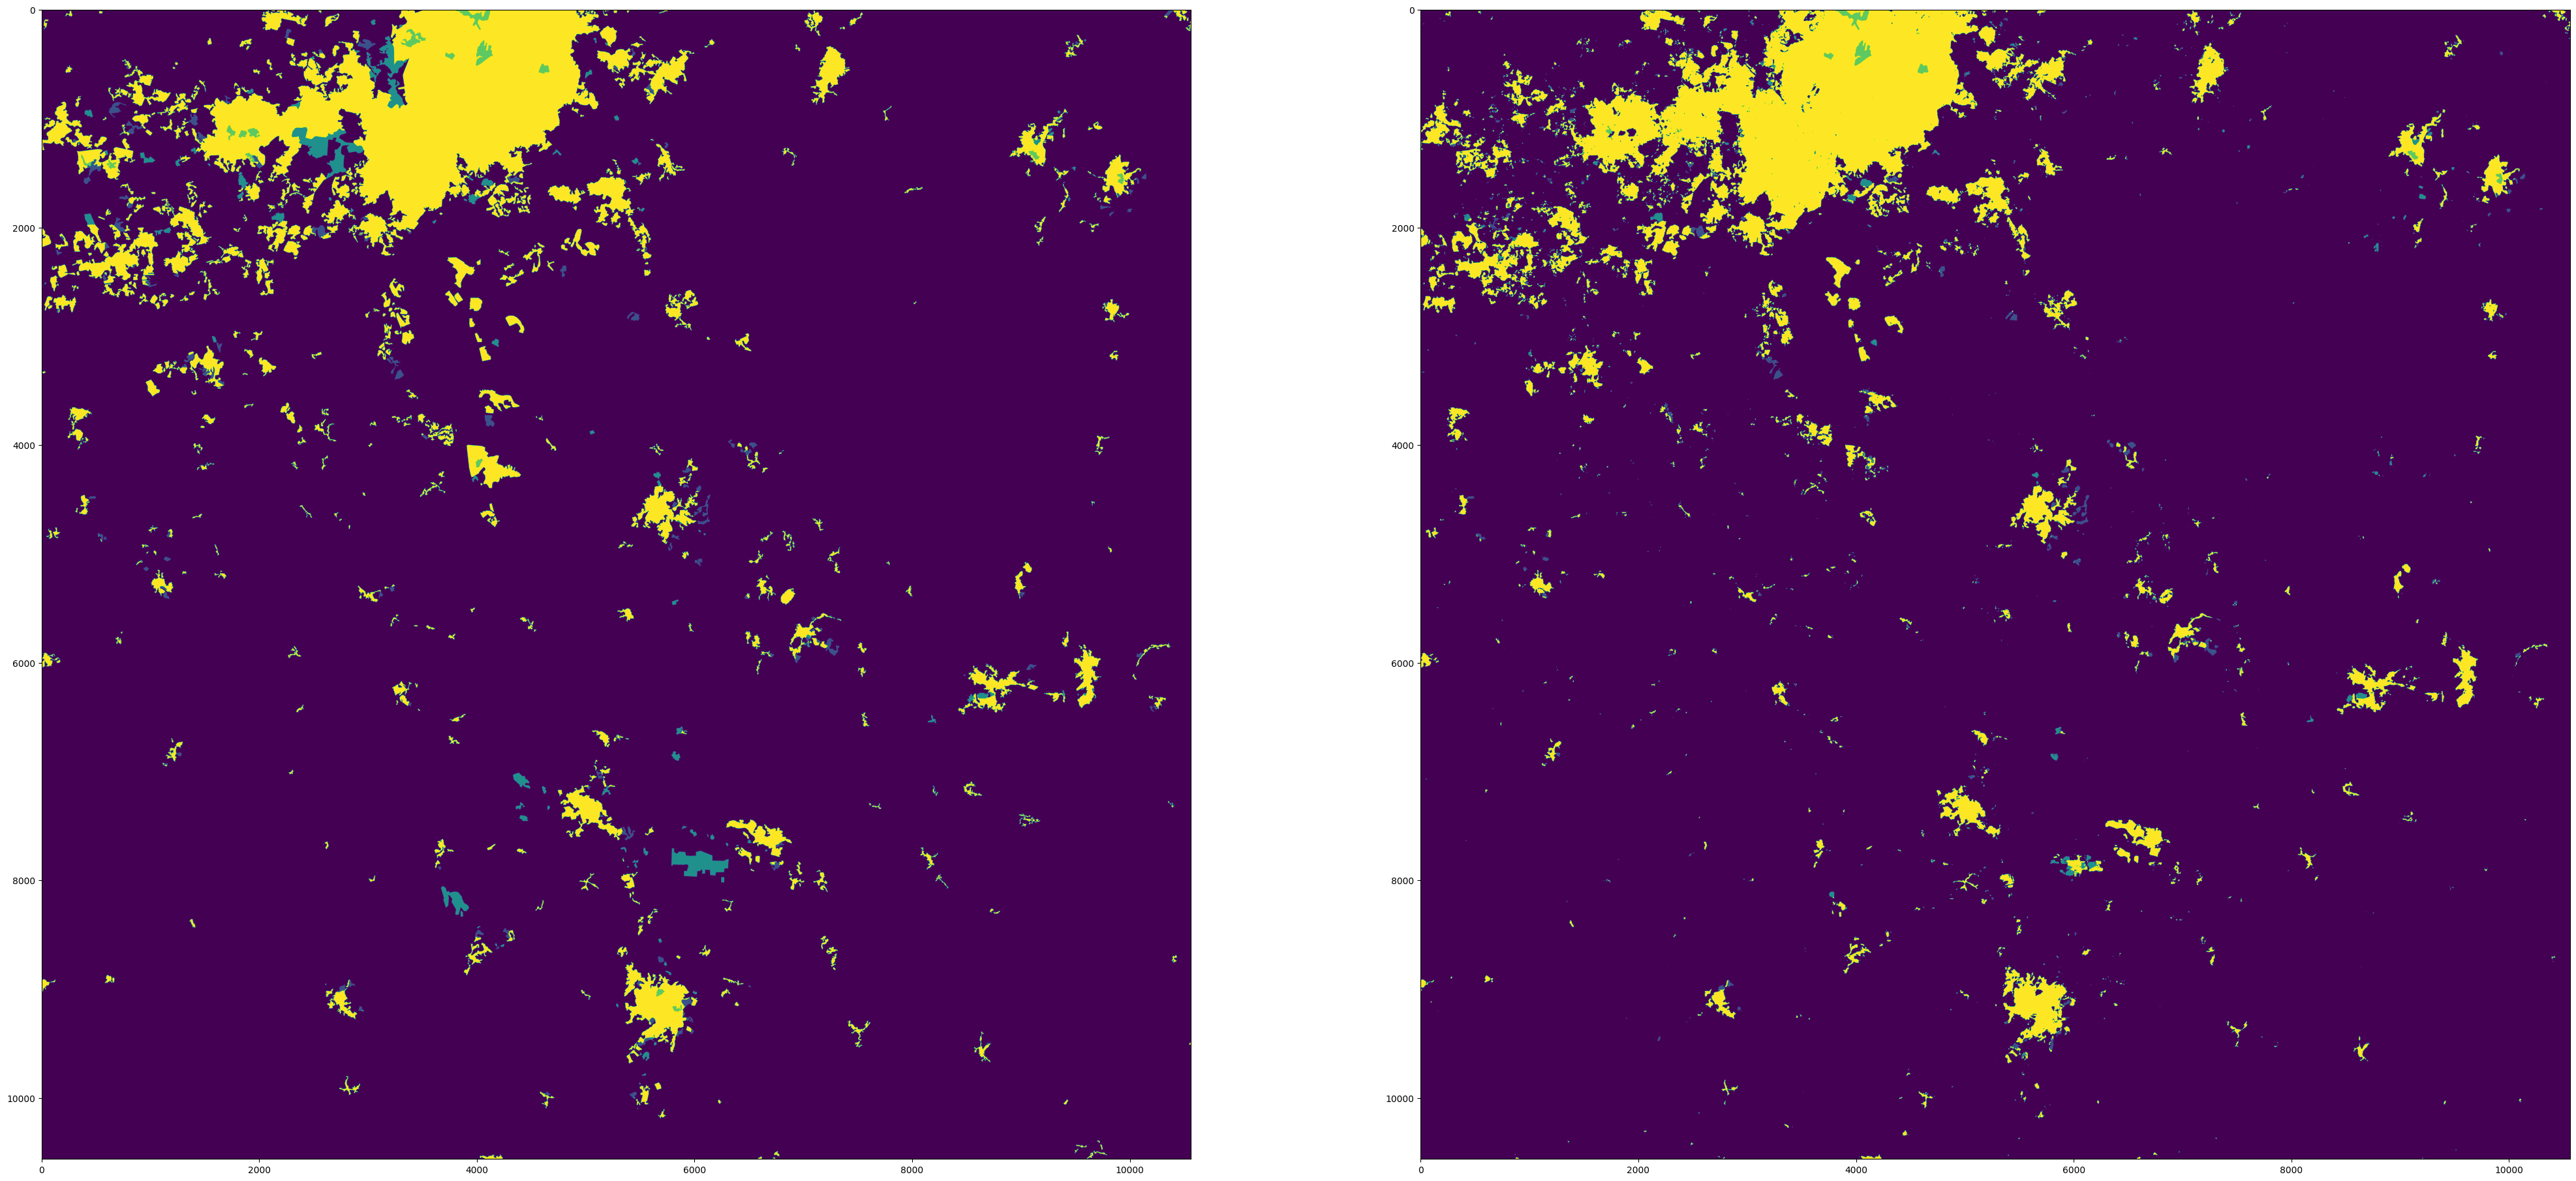

In [5]:
for tile_id in ['032027']:#, '025037', '032027']:
    for model_dict in models:
        model_name = model_dict['model_name']
        ckp_file = os.path.join(working_dir, 'models', model_name+'.pth')
        print('Model name:', model_name)
        if model_name.startswith('UNetSmall-'):
            model = unets.UNetSmall(in_channels=12, out_channels=num_classes).to(device) 
        elif model_name.startswith('UNet-'):
            model = unets.UNet(in_channels=12, out_channels=num_classes).to(device) 
        elif model_name.startswith('UNetResNet34-'):
            model = unets.UNetResNet34(in_channels=12, out_channels=num_classes).to(device) 
        elif model_name.startswith('UNetEfficientNetB0-'):
            model = unets.UNetEfficientNetB0(in_channels=12, out_channels=num_classes).to(device) 
        elif model_name.startswith('UNetConvNext-'):
            model = unets.UNetConvNext(in_channels=12, out_channels=num_classes).to(device) 
        elif model_name.startswith('HRNetW18'):
            model = hrnets.HRNetSegmentation(in_channels= 12, num_classes=num_classes, backbone="hrnet_w18_small", pretrained=True,).to(device)
        elif model_name.startswith('HRNetW32'):
            model = hrnets.HRNetSegmentation(in_channels= 12, num_classes=num_classes, backbone="hrnet_w32", pretrained=True,).to(device)
        elif model_name.startswith('HRNetW48'):
            model = hrnets.HRNetSegmentation(in_channels= 12, num_classes=num_classes, backbone="hrnet_w48", pretrained=True,).to(device)
        else:
            print('Nao existe esse modelo')
            continue
        checkpoint = torch.load(ckp_file, weights_only=False)
        model.load_state_dict(checkpoint['best_model_state_dict'])

        patch_size = model_dict['patch_size']
        stride = patch_size-32
        edge_removal = 8
        if patch_size == 64:
            stride = patch_size-16
            edge_removal = 4

        # --------------- opening files -----------------
        folder = os.path.join(working_dir,f"data/processed/S2-16D_V2_{tile_id}/{num_subtiles}x{num_subtiles}_subtiles")
        files = os.listdir(folder)
        files = [os.path.join(folder, f) for f in files if f.endswith('.tif')]
        # --------------- creating a dataloader -----------------
        tile_dataset = data.SubtileDataset(files, 
                                        num_subtiles = 6,
                                        classes_mode=classes_mode,
                                        patch_size=patch_size, 
                                        stride=stride, #//2, 
                                        dynamic_sampling = False,
                                        data_augmentation = False, 
                                        return_imgidx = True)
        dataloader = DataLoader(tile_dataset, batch_size=model_dict['batch_size'], shuffle=False)
        
        tile = post.ReconstructTile(patch_size = patch_size, stride = stride, edge_removal=edge_removal)


        import time
        torch.cuda.reset_peak_memory_stats()
        run_time = time.time()

        print('Inferindo...')        
        runner = train.EpochRunner('test', model, dataloader, num_classes=num_classes, 
                                    simulated_batch_size = dataloader.batch_size, device = device)  
        for image, label, logits, pred, x, y, f, in runner.run_generator(show_pred = 0):
            tile.add_batch(x, y, f, logits, pred, label, image)
            #print(np.unique(tile.preds))
        print('Montando...')
        tile.set_pred()      
        print('Salvando...')        
        tile.save_pred(tile_id, folder_name = model_dict['model_name'])
            
        loss, CE, dice, report, acc, cm = runner.get_metrics()
        run_time = time.time()-run_time
        peak_train_memory = f"{torch.cuda.max_memory_allocated() / 1024 ** 2:.2f} MB"
        torch.cuda.empty_cache()

         # Replace with actual variable
        
        
        print(f'Test Loss: {loss}, {CE}, {dice}')
        print(f'Test Accuracy: {acc}')
        print(f'Test confusion matrix:')
        view.plot_confusion_matrix(cm)
        print(report)
        
        #### ----------------- Contruct tile
        
        

        r = [0, 10560, 0, 10560]
        #r = [5000, 7000, 1000, 3000]

        plt.figure(figsize=(50, 50))
        plt.subplot(1,2,1)
        plt.imshow(tile.labels[r[0]:r[1], r[2]:r[3]])
        plt.subplot(1,2,2)
        plt.imshow(tile.preds[r[0]:r[1], r[2]:r[3]])
        plt.show()
        
        del tile
        import gc
        gc.collect()